In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Directive = '/content/drive/MyDrive/Centrale Marseille/3A/SAM/Projet/'

In [ ]:
#!pip install --upgrade --quiet librosa

In [ ]:
import numpy as np
import matplotlib.pyplot as plt, matplotlib.image as mpimg
import sys
sys.path.append(Directive)

In [ ]:
import zipfile
with zipfile.ZipFile(Directive + 'msdi.zip' , 'r') as zip:
    zip.extractall('msdi')

In [ ]:
!ls msdi/

deep_features  img  labels.csv	mfcc  msdi_mapping.csv	README.md


In [ ]:
!head msdi/msdi_mapping.csv

,msd_track_id,genre,album_index,set,msd_artist_id,image_url,img,mfcc,deep_features
0,TRABKJU128F422A7FE,Metal,0,train,ARBD4QW1187FB42153,http://artwork-cdn.7static.com/static/img/sleeveart/00/008/487/0000848744_200.jpg,img/0000848744_200.jpg,mfcc/mfcc_A.npz,0
1,TRBLDQQ128F92E58B4,Rock,1,train,AR3RK011187FB3CE3B,http://artwork-cdn.7static.com/static/img/sleeveart/00/004/765/0000476534_200.jpg,img/0000476534_200.jpg,mfcc/mfcc_B.npz,1
2,TRDMMDE128F14A9052,Rock,2,train,ARJVTRE1187B9959C0,http://artwork-cdn.7static.com/static/img/sleeveart/00/000/623/0000062345_200.jpg,img/0000062345_200.jpg,mfcc/mfcc_D.npz,2
3,TRJOPZB128F4250E02,Rock,4,train,AR62BB21187B9AC83D,http://artwork-cdn.7static.com/static/img/sleeveart/00/001/447/0000144785_200.jpg,img/0000144785_200.jpg,mfcc/mfcc_J.npz,3
4,TRJKBVL128F935567B,Rock,5,train,AR7GVOV1187B9B5FF1,http://artwork-cdn.7static.com/static/img/sleeveart/00/005/205/0000520513_200.jpg,img/0000520513_200.jpg,mfcc/mfcc_J.npz,4
5,TRUSOQD128F92CFEA5,Rock,7,train,AR

# Introduction

L'objectif de cette partie est de développer un modèle unimodal permettant de classifier des données de pochette d'album en fonction de leur genre musical.

Pour cela, nous allons analyser différentes features afin de déterminer lesquelles sont les plus efficaces dans la réalisation de cette tâche.
Les 4 features ici étudiés sont l'échantillonnage naïf de la pochette, la réalisation d'une moyenne par bloc, l'histogramme par bloc et le hog.

La première partie est consacrée à l'observation de ces features sur un exemple.
La seconde consiste à récupérer ces features sur l'ensemble de nos données.
La dernière implémente plusieurs classifieurs et détermine lequel est le plus performant pour notre tâche.

## Chargement de l'image

In [ ]:
image_path = 'msdi/img/'
image_filename = image_path + '0000000028_200.jpg'
x = plt.imread(image_filename)
print('Format de l image chargée:',x.shape)

Format de l image chargée: (200, 200, 3)


In [ ]:
x

array([[[  0,   1,   4],
        [  0,   1,   4],
        [  0,   1,   4],
        ...,
        [  0,   1,   4],
        [  0,   1,   4],
        [  0,   1,   4]],

       [[  3,   7,  10],
        [  3,   7,  10],
        [  3,   7,  10],
        ...,
        [  5,   9,  12],
        [  5,   9,  12],
        [  5,   9,  12]],

       [[  7,  11,  14],
        [  7,  11,  14],
        [  7,  11,  14],
        ...,
        [ 12,  16,  19],
        [ 12,  16,  19],
        [ 12,  16,  19]],

       ...,

       [[ 83,  97, 108],
        [108, 122, 133],
        [115, 129, 140],
        ...,
        [ 56,  73,  83],
        [ 55,  72,  82],
        [ 65,  82,  92]],

       [[ 78,  92, 103],
        [ 81,  95, 106],
        [ 86, 100, 111],
        ...,
        [ 39,  56,  66],
        [ 35,  52,  62],
        [ 37,  54,  64]],

       [[  0,   3,  12],
        [  0,   3,  12],
        [  0,  10,  19],
        ...,
        [  0,   8,  17],
        [  0,   6,  15],
        [  0,   3,  12]]

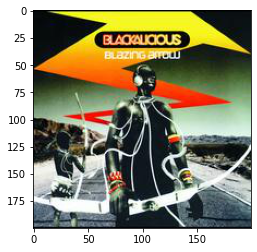

In [ ]:
# Affichage de l'image 
plt.imshow(x)

In [ ]:
# Défintion de quelques paramètres 
P = Q = 3   # P×Q cellules 
B = 8   # nombre de bins

# Observation des différentes features

## Affichage de l'échantillonnage naïf

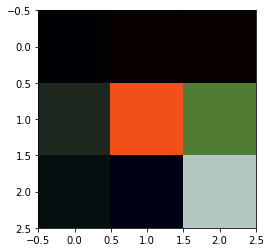

In [ ]:
# Echantillonage 3x3 naif de l'image
plt.imshow(x[::x.shape[0] // P + 1, 0::x.shape[1] // Q + 1])

## Affichage de la moyenne par bloc

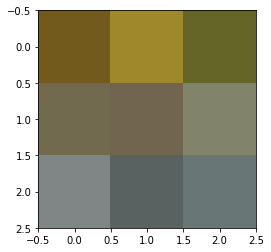

In [ ]:
import skimage.transform

# Echantillonnage 3x3 en réalisant la moyenne par bloc de l'image
plt.imshow(skimage.transform.resize(x, output_shape=(P, Q)))

## Affichage de l'histogramme

<BarContainer object of 8 artists>

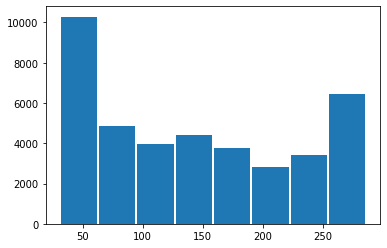

In [ ]:
import numpy as np

# Affichage de l'histogramme de l'image pour la composante verte
heights, bin_edges = np.histogram(x[:, :, 1], bins=8, range=(0, 255))
plt.bar(bin_edges[1:], heights, align='edge', width=30)

<BarContainer object of 8 artists>

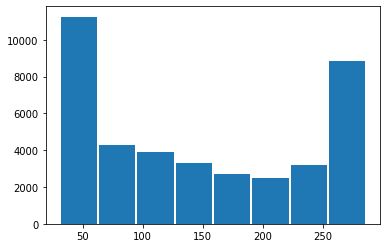

In [ ]:
# Affichage de l'histogramme de l'image pour la composante rouge
heights, bin_edges = np.histogram(x[:, :, 0], bins=8, range=(0, 255))
plt.bar(bin_edges[1:], heights, align='edge', width=30)

## Affichage du gradient

Text(0.5, 1.0, 'Gradient vertical')

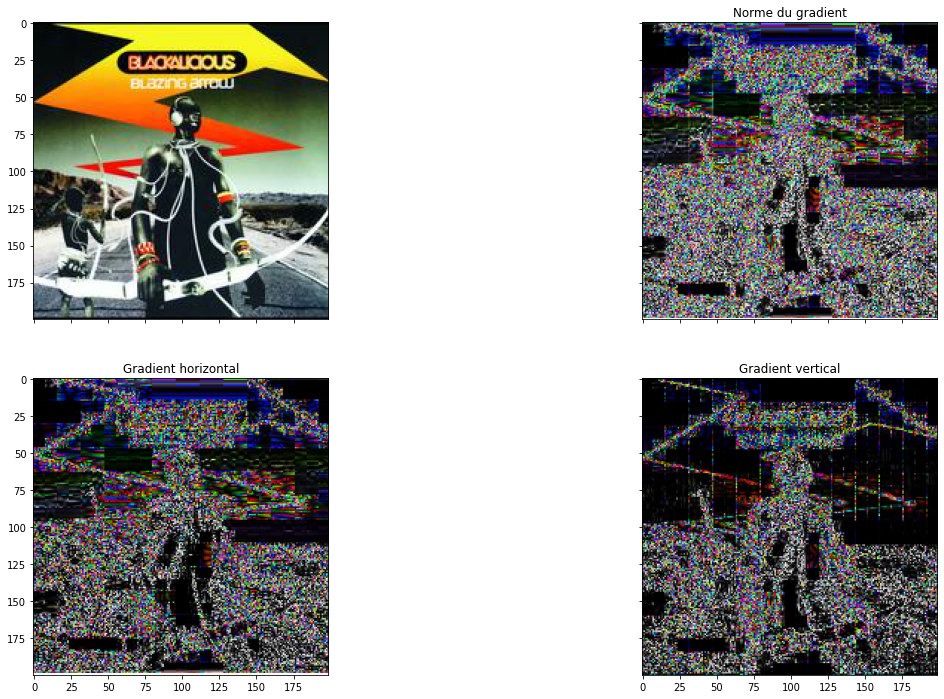

In [ ]:
# Affichage image et gradients de l'image :
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12), sharex=True, sharey=True)
ax1.imshow(x)
ax2.imshow(np.diff(x, axis=0)[:,:-1]**2+np.diff(x, axis=1)[:-1,:]**2)
ax2.set_title('Norme du gradient')
ax3.imshow(np.diff(x, axis=0)**2)
ax3.set_title('Gradient horizontal')
ax4.imshow(np.diff(x, axis=1)**2)
ax4.set_title('Gradient vertical')

## Affichage du HOG

(72,)


Text(0.5, 1.0, 'HOG (few cells)')

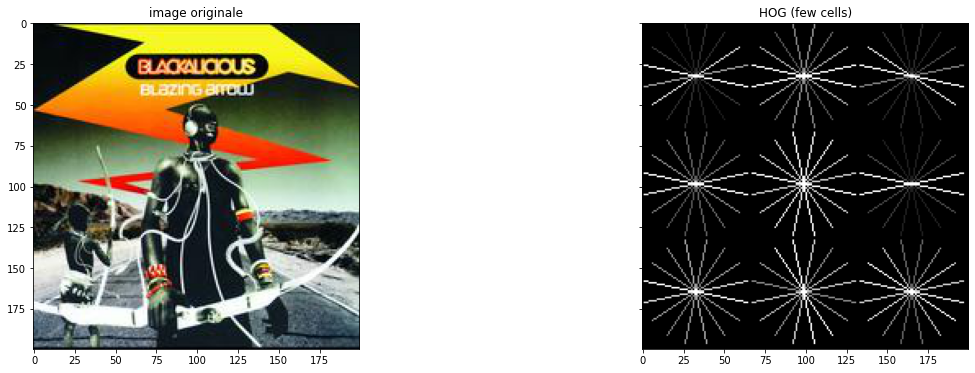

In [ ]:
# On calcule les HOG pour l'image étudiée et afficher l'image correspondante

from skimage.feature import hog
from skimage import exposure


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharex=True, sharey=True)

# Affichage de l'image de départ
ax1.imshow(x, cmap=plt.cm.gray)
ax1.set_title('image originale')

# Calcul du HOG
hog_vector, hog_image = hog(x, orientations=B, pixels_per_cell=(x.shape[0]//P, x.shape[1]//Q),
                        cells_per_block=(1, 1), visualize=True, multichannel=True)
print(hog_vector.shape)

# Affichage hog_image
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) # Rescale de hog_image
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG (few cells)')

# Récupération des features de l'ensemble des images

In [ ]:
# Fonction nous permettant de récupérer l'échantillonage naïf pour chaque image :
def extract_naive(image, P=P, Q=Q):
    return image[::image.shape[0] // P + 1, ::image.shape[1] // Q + 1].flatten()

In [ ]:
# Fonction nous permettant de récupérer la moyenne par bloc pour chaque image :
def extract_mean(image, P=P, Q=Q):
    return skimage.transform.resize(image, output_shape=(P, Q), anti_aliasing=True).flatten()

In [ ]:
# Fonction nous permettant de récupérer les histogrammes par bloc pour chaque image :
def extract_hist(image, P=P, Q=Q, B=B):
    M = (image.shape[0]//P)+1
    N = (image.shape[1]//Q)+1
    tiles = [image[x:x+M,y:y+N] for x in range(0,image.shape[0],M) for y in range(0,image.shape[1],N)]
    return np.concatenate([np.histogram(tile[:,:,c].reshape(-1), bins=B, range=(0, 255))[0] for c in range(image.shape[2]) for tile in tiles])

In [ ]:
# Fonction nous permettant de récupérer le HOG_vector pour chaque image :
def extract_hog(image, P=P, Q=Q, B=B):
  return hog(image, orientations=B, pixels_per_cell=(image.shape[0]//P, image.shape[1]//Q), cells_per_block=(1, 1), multichannel=True)

In [ ]:
# On récupère les données msdi qui nous intéressent dans le fichier csv

import csv

filenames = []
y = []

compteur = 0
msdi_path = 'msdi/'
with open(msdi_path + 'msdi_mapping.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    next(reader, None) # on saute la première ligne qui ne nous intéresse pas
    for row in reader:
        filename = row[7]
        if filename in filenames:
            style = y[filenames.index(filename)]
            if style != row[2]:
                compteur += 1
        else:
            filenames.append(filename)
            y.append(row[2])


print(len(filenames), set(y), compteur)

16803 {'Latin', 'New Age', 'Blues', 'Metal', 'Jazz', 'Electronic', 'Rap', 'RnB', 'Pop', 'Rock', 'Country', 'World', 'Reggae', 'Folk', 'Punk'} 197


In [ ]:
# on utilise ici l'échantillonage naïf 3x3 pour définir nos features
X_naive = []
for filename in filenames:
    image = plt.imread(msdi_path + filename)
    X_naive.append(extract_naive(image))

In [ ]:
# on utilise ici l'échantillonage par moyenne par blocs 3x3 pour définir nos features
X_mean = []
for filename in filenames:
    image = plt.imread(msdi_path + filename)
    X_mean.append(extract_mean(image))

In [ ]:
# on utilise ici l'échantillonage par histogrammes par blocs 3x3 pour définir nos features
X_hist = []
for filename in filenames:
    image = plt.imread(msdi_path + filename)
    X_hist.append(extract_hist(image))

In [ ]:
# on utilise ici les HOG 3x3 pour définir nos features
X_hog = []
for filename in filenames:
    image = plt.imread(msdi_path + filename)
    X_hog.append(extract_hog(image))

# Classification

## Recherche du meilleur classifieur

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifiers = [
    MLPClassifier(max_iter=2000),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier()
]

scores = []
for X in [X_naive, X_mean, X_hist, X_hog]:
  for clf in classifiers:
    # réinitialisation pipeline :
    pipeline_im = make_pipeline(StandardScaler(), clf)
    # séparation data train et data test :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    print(f'Classifier: {clf.__class__.__name__}')
    print(f'X_train: {np.shape(X_train)}, y_train: {np.shape(y_train)}, X_test: {np.shape(X_test)}, y_test: {np.shape(y_test)}')
    # entrainement et évaluation en test
    pipeline_im.fit(X_train, y_train)
    score = pipeline_im.score(X_test, y_test)
    scores.append((clf.__class__.__name__, score))
    print(f'Score: {score}\n')

print(f'Final scores: {scores}')


Classifier: MLPClassifier
X_train: (13442, 27), y_train: (13442,), X_test: (3361, 27), y_test: (3361,)
Score: 0.21511454924129722

Classifier: SVC
X_train: (13442, 27), y_train: (13442,), X_test: (3361, 27), y_test: (3361,)
Score: 0.23356144004760487

Classifier: DecisionTreeClassifier
X_train: (13442, 27), y_train: (13442,), X_test: (3361, 27), y_test: (3361,)
Score: 0.13031835763165725

Classifier: RandomForestClassifier
X_train: (13442, 27), y_train: (13442,), X_test: (3361, 27), y_test: (3361,)
Score: 0.2368342755132401

Classifier: MLPClassifier
X_train: (13442, 27), y_train: (13442,), X_test: (3361, 27), y_test: (3361,)
Score: 0.20916393930377863

Classifier: SVC
X_train: (13442, 27), y_train: (13442,), X_test: (3361, 27), y_test: (3361,)
Score: 0.23147872656947338

Classifier: DecisionTreeClassifier
X_train: (13442, 27), y_train: (13442,), X_test: (3361, 27), y_test: (3361,)
Score: 0.14251710800357037

Classifier: RandomForestClassifier
X_train: (13442, 27), y_train: (13442,), X

Finalement, le modèle le plus performant correspond à l'utilisation du HOG de l'image avec un classifieur de type RandomForestClassifier, obtenant alors un résultat de 25,68%.

Classifier: RandomForestClassifier
X_train: (13442, 72), y_train: (13442,), X_test: (3361, 72), y_test: (3361,)
Score: 0.2567688188039274

## Recherche de ses hyperparamètres optimaux

In [ ]:
from sklearn.model_selection import GridSearchCV

# Définition des hyperparamètres à tester
param_grid = {'n_estimators': [10, 50, 100, 200], 'max_depth': [3, 5, 7, 9]}

# Initialisation du classifieur
clf = RandomForestClassifier()

# Initialisation de GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Séparation data train et data test :
X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.2)

# Réalisation du gridsearch sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Affichage des meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres: ", grid_search.best_params_)

# Evaluation du modèle avec les meilleurs hyperparamètres sur les données de test
score = grid_search.score(X_test, y_test)
print("Score: ", score)



Meilleurs hyperparamètres:  {'max_depth': 9, 'n_estimators': 50}
Score:  0.2537935138351681


# Conclusion
La features permettant d'obtenir une meilleure prédiction sur le genre d'une musique (25,7%) à partir de sa pochette d'album est le descripteur de forme historique: HOG (25,7%). Cela peut s'expliquer par plusieurs raisons:



*   Représentation visuelle robuste : Le HOG capture les structures visuelles clés d'une image tout en minimisant l'influence des variations non pertinentes telles que la luminosité et la saturation. Cela permet de produire une représentation visuelle robuste qui peut être utilisée pour la reconnaissance d'images et la classification.
*   Invariance à la rotation et à l'échelle : Le HOG est conçu pour être invariant à la rotation et à l'échelle, ce qui signifie que les images similaires auront des représentations HOG similaires, même si elles sont tournées ou agrandies/réduites.
*   Traitement local : Le HOG traite chaque partie de l'image de manière indépendante, ce qui permet d'extraire des caractéristiques locales telles que les formes, les textures et les orientations.



En comparant avec l'histogramme de couleur ou la couleur moyenne par bloc ou l'échantillonnage naïf, le HOG peut être considéré comme un choix plus performant pour la reconnaissance d'images et la classification car il fournit une représentation visuelle plus robuste et plus invariente pour les images.




Cependant cette tâche reste très difficile. En effet, le genre d'une musique et sa pochette d'album ont un lien très souvent indirect, ce qui nous explique sa faible performance. Nous verrons dans un deuxième temps son utilité dans le cas multimodal.